In [1]:
import numpy as np
from math import *
import pandas as pd
from scipy import stats, optimize
import itertools

# Management of dates and time
from datetime import datetime
from dateutil.relativedelta import relativedelta
from time import strftime, time
from timeit import timeit

# Curve Fitting
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

# Pretty Table
from prettytable import PrettyTable

# Plot
import matplotlib.pyplot as plt

In [2]:
'''CALIBRATION DATA
====================='''
loc = "Data\\01 - Calibration Data.xlsx"

#Obtain ATM Normal Volatility Data
vol_data = pd.read_excel(loc,
                        sheet_name = "ATM Swaptions Normal Vol",
                        skiprows= [0, 2,3],
                        index_col = "Dates")

# Decimal Notation
vol_data = pd.DataFrame.dropna(vol_data, axis = 'rows')/10000
# vol_data = vol_data[(vol_data.T ==0).any() == False]

# Obtain OIS Discount Data
eonia_data = pd.read_excel(loc, 
                   sheet_name = "EONIA Rates",
                   skiprows= [0, 1,3],
                   index_col = "Dates")

# Decimal Notation
eonia_data = pd.DataFrame.dropna(eonia_data, axis = 'rows')/100
eonia_data = eonia_data.loc[vol_data.index]

# Obtain Swap Curve Data
swap_data = pd.read_excel(loc,
                        sheet_name = "Swap Rates Data",
                        skiprows= [0, 1,3],
                       index_col = "Dates")

# Decimal Notation
swap_data = pd.DataFrame.dropna(swap_data, axis = 'rows')/100
swap_data = swap_data.loc[vol_data.index]

In [3]:
'''CURVE SETUP
================='''
# OIS/EONIA Maturities
eoniaMaturities = np.array(([i/52 for i in range(1, 5)] + # Weeks
                          [i/12 for i in range(2, 24)]+   # Months
                           [2, 30/12]+                    # Years
                           [i for i in range(3, 15)]+     # 5 Year Intervals
                           [i*5 for i in range(3, 9)]+[50])) # 50 years

# Swap Rate maturities
swapMaturities = np.array(([i for i in range(1,31)] + # Years
                          [i*5 for i in range(7, 13)])) # 50 years

''' SWAP RATE INTERPOLATION'''
'''Piecewise Linear Interpolation -Used in Bloomberg'''
# Range of dates for each maturity
fullMaturities = np.arange(1, 61)
fullSwapData = pd.DataFrame([np.interp(fullMaturities, 
                                       swapMaturities, swap_data.loc[date])
               for date in swap_data.index],
                    columns = list(range(1, 61)),
                    index = swap_data.index)

'''ZERO COUPON BOOTSTRAPPING (Single Curve)'''
# Construct Zero Coupon Prices for each maturity
# We already have the first ZC date
zeroCoupons = []

# Loop to calculate the ZC prices from swap curves
for j in range(len(swap_data.index)):
    curve = np.array(fullSwapData.loc[swap_data.index[j]])
    zeroCoupons.append([])
    
    for i in range(0, 60):
        zeroCoupons[j].append((1 - curve[i] * np.sum(zeroCoupons[j][:i]))/
                                           (1 + curve[i]))

# Save zeroCoupons as a dataframe
zeroCoupons = pd.DataFrame(zeroCoupons,
                    columns = list(range(1, 61)),
                    index = swap_data.index)

'''FORWARD CURVE CONSTRUCTION'''
#Range of end dates for forwards ie date K for F(t; K, K+1)
forwardStartDates = np.arange(2, 61)

forwardCurves = []

# Loop to calculate forward prices from ZC Prices
for j in range(len(swap_data.index)):
    curve = np.array(zeroCoupons.loc[swap_data.index[j]])
    forwardCurves.append([(curve[i-1]/curve[i])-1 for i in range(1, len(curve))])

        
# Save forwards as a dataframe
forwardCurves = pd.DataFrame(forwardCurves,
                    columns = list(range(1, 60)),
                    index = swap_data.index)

In [4]:
''' KEY FUNCTIONS
================
NOTE: Bias in the resulting Forward Swap Rate of 4bps'''
'''Linear Interpolator for ZC Prices'''
def zeroCouponInterpolator(evalDate, forwardDate):
    '''ACT/365 Day Count Convention'''
    curve = zeroCoupons.loc[evalDate]
    rate = np.interp((datetime.strptime(forwardDate,'%Y-%m-%d')- 
                datetime.strptime(evalDate,'%Y-%m-%d' )).days/365,
                fullMaturities, 
                curve)
    return(rate)


'''Forward Rate Calculator'''
def forwardRate(evalDate, forwardEndDate):
    forwardCurve =  forwardCurves.loc[evalDate]
    rate = np.interp((datetime.strptime(forwardEndDate,'%Y-%m-%d')- 
                datetime.strptime(evalDate,'%Y-%m-%d' )).days/365,
                forwardStartDates, 
                forwardCurve)
    return(rate)

#Important for the next step
zeroCouponVect = np.vectorize(zeroCouponInterpolator)

'''Forward Swap Rate Calculator'''
def forwardSwapRate(evalDate, expiryDate, tenorDate):
    num = zeroCouponInterpolator(evalDate, expiryDate) - zeroCouponInterpolator(evalDate, tenorDate) 
    
    # Find the PVBP of the underlying swap
    expiry = datetime.strptime(expiryDate,'%Y-%m-%d')
    tenor = datetime.strptime(tenorDate,'%Y-%m-%d')

    # Find all payment dates for the swaption
    paymentDates = [datetime.strftime(expiry + relativedelta(years = i+1), '%Y-%m-%d') 
                for i in range(tenor.year - expiry.year)]
    
    PVBP = np.sum(zeroCouponVect(evalDate, paymentDates))
    
    return(num/PVBP)

In [5]:
'''PRICERS
==============='''
' Black Pricer - Payer'
def blackPayer(N, S0, K, evalDate, maturityDate, tenorDate, sigma):
    eDate = datetime.strptime(evalDate, '%Y-%m-%d')
    maturity = datetime.strptime(maturityDate, '%Y-%m-%d')
    tenor = datetime.strptime(tenorDate, '%Y-%m-%d')
    
    # Find all payment dates for the swaption
    paymentDates = [datetime.strftime(maturity + relativedelta(years = i+1), '%Y-%m-%d') 
                    for i in range(tenor.year - maturity.year)]
    
    # Find Zero Coupon Price at each date and calculate PVBP
    PVBP = np.sum(zeroCouponVect(evalDate, paymentDates))
    
    # Define Black Parameters
    T = (maturity - eDate).days/365
    d1 = (log(S0/K) + 0.5*(pow(sigma,2)*T))/(sigma * sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    
    price = N*PVBP * (S0*stats.norm.cdf(d1) - K*stats.norm.cdf(d2))
    return(price)


' Chi Square Pricer - Payer'
def chiSquarePayer(N, S0, K, evalDate, maturityDate, tenorDate, sigma, beta, delta):
    eDate = datetime.strptime(evalDate, '%Y-%m-%d')
    maturity = datetime.strptime(maturityDate, '%Y-%m-%d')
    tenor = datetime.strptime(tenorDate, '%Y-%m-%d')
    
    # Find all payment dates for the swaption
    paymentDates = [datetime.strftime(maturity + relativedelta(years = i+1), '%Y-%m-%d') 
                    for i in range(tenor.year - maturity.year)]
    
    # Find Zero Coupon Price at each date and calculate PVBP
    PVBP = np.sum(zeroCouponVect(evalDate, paymentDates))
    
    # Parameters for input into Chi Square CDF
    T = (maturity - eDate).days/365
    d = (pow(K+delta,2 - 2*beta))/(pow(1 - beta,2)*pow(sigma,2)* T)
    b = 1/(1 - beta)
    f = (pow(S0+delta, 2 - 2*beta))/(pow(1 - beta, 2)*pow(sigma, 2)* T)

    # Calculate Price
    price = N * PVBP * ((S0+delta)*(1 - stats.ncx2.cdf(d, b+2, f)) - (K+delta)*(stats.ncx2.cdf(f, b, d)))
    return(price)


def normalPayer(N, S0, K, evalDate, maturityDate, tenorDate, sigma):
    eDate = datetime.strptime(evalDate, '%Y-%m-%d')
    maturity = datetime.strptime(maturityDate, '%Y-%m-%d')
    tenor = datetime.strptime(tenorDate, '%Y-%m-%d')
    
    # Find all payment dates for the swaption
    paymentDates = [datetime.strftime(maturity + relativedelta(years = i+1), '%Y-%m-%d') 
                    for i in range(tenor.year - maturity.year)]
    
    # Find Zero Coupon Price at each date and calculate PVBP
    PVBP = np.sum(zeroCouponVect(evalDate, paymentDates))
    
     # Define Black Parameters
    T = (maturity - eDate).days/365
    d1 = (S0 - K)/(sigma * sqrt(T))
    
    #Calculate Price
    price = N * PVBP * ((S0 - K)*stats.norm.cdf(d1) + (sigma * sqrt(T)* exp(-0.5 * pow(d1, 2)))/sqrt(2 * pi))
    return(price)

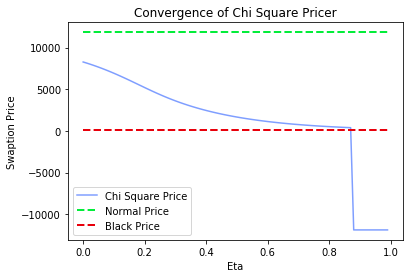

In [15]:
# Select Parameters
N, S0, K, evalDate, maturityDate, tenorDate = 1e+5, 0.01, 0.01, '2018-12-31', '2019-12-31', '2025-12-31'
delta = 0.01
sigma = 0.05
Betas = np.arange(0, 10000, 100)/10000

chiPrices = [chiSquarePayer(N, S0, K, evalDate, maturityDate, tenorDate, sigma, beta, delta) for beta in Betas]
blackPrice = blackPayer(N, S0, K, evalDate, maturityDate, tenorDate, sigma)
normalPrice = normalPayer(N, S0, K, evalDate, maturityDate, tenorDate, sigma)
plt.plot(Betas,chiPrices, alpha=0.5)
plt.plot(Betas, np.repeat(normalPrice, len(Betas)), lw=2, ls='--',dash_capstyle='butt')
plt.plot(Betas, np.repeat(blackPrice, len(Betas)), lw=2, ls='--',dash_capstyle='butt')
plt.style.use('seaborn-bright')
plt.title('Convergence of Chi Square Pricer')
plt.xlabel('Eta')
plt.ylabel('Swaption Price')
plt.legend(['Chi Square Price', 'Normal Price', 'Black Price'], loc=3)
plt.grid(False)

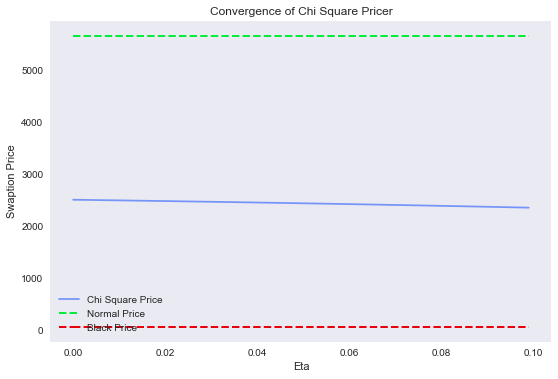

In [144]:
# Select Parameters
N, S0, K, evalDate, maturityDate, tenorDate = 1e+5, 0.01, 0.01, '2018-12-31', '2020-12-31', '2021-12-31'
delta = 0.02
sigma = 0.1
Betas = np.arange(0, 10000, 100)/100000

chiPrices = [chiSquarePayer(N, S0, K, evalDate, maturityDate, tenorDate, sigma, beta, delta) for beta in Betas]
blackPrice = blackPayer(N, S0, K, evalDate, maturityDate, tenorDate, sigma)
normalPrice = normalPayer(N, S0, K, evalDate, maturityDate, tenorDate, sigma)
plt.plot(Betas,chiPrices, alpha=0.5)
plt.plot(Betas, np.repeat(normalPrice, len(Betas)), lw=2, ls='--',dash_capstyle='butt')
plt.plot(Betas, np.repeat(blackPrice, len(Betas)), lw=2, ls='--',dash_capstyle='butt')
plt.style.use('seaborn-bright')
plt.title('Convergence of Chi Square Pricer')
plt.xlabel('Eta')
plt.ylabel('Swaption Price')
plt.legend(['Chi Square Price', 'Normal Price', 'Black Price'], loc=3)
plt.grid(False)